In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
#import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
#df_path = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
df = pd.read_csv(df_path)

Need to rescale predictions and targets

In [228]:
# GET this working so that we go from dataframe to the appropriate (and appropriately shaped) tensors, set up function that does this and creates that dictionary

In [162]:
    features = []
    targets = []
    precision = []
    normed_targets = []
    for i in df.voxel.unique():
        features.append(df[df.voxel==i][['local_sf_magnitude', 'local_sf_xy_direction', 'eccen', 'angle']].values)
        targets.append(df[df.voxel==i]['amplitude_estimate_median'].values)
        normed_targets.append(df[df.voxel==i]['amplitude_estimate_median_normed'].values)
        precision.append(df[df.voxel==i]['precision'].values)
    #features = tt.as_tensor(features)
    #targets = tt.as_tensor(targets)
    #precision = tt.as_tensor(precision)


In [227]:
%%timeit
a=df.groupby(['voxel', 'stimulus_class'])[['local_sf_magnitude']].mean().unstack().to_numpy()
tt.as_tensor(a)

4.57 ms ± 89.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [226]:
%%timeit
features = []
for i in df.voxel.unique():
    features.append(df[df.voxel==i][['local_sf_magnitude']].values.squeeze())
tt.as_tensor(features)

180 ms ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [143]:
def pymc_log_gauss_donut(df, orientation_type='iso', eccentricity_type='full', vary_amplitude=False):
    random_param, param_val = {}, {}
    for ori, param, angle in itertools.product(['abs', 'rel'], ['mode', 'amplitude'],
                                               ['cardinals', 'obliques']):
        random_param['%s_%s_%s' % (ori, param, angle)] = True
        param_val['%s_%s_%s' % (ori, param, angle)] = 0
    for var in ['slope', 'intercept']:
        random_param['sf_ecc_%s' % var] = True
        param_val['sf_ecc_%s' % var] = .5
    param_val, random_param = sfp.model._check_log_gaussian_params(param_val, random_param, orientation_type, 
                                                                   eccentricity_type, vary_amplitude)
    params = {}
    sf_mag_t = theano.shared(features[:,:,0])
    sf_angle_t = theano.shared(features)
    vox_ecc_t = theano.shared(features.eccen.values)
    vox_angle_t = theano.shared(features.angle.values)
    targets_t = theano.shared(targets.values.squeeze())
    precision_t = theano.shared(precision.values.squeeze())
    map_tensor_batch = {sf_mag_t: pm.Minibatch(features.local_sf_magnitude.values, 100),
                        sf_angle_t: pm.Minibatch(features.local_sf_xy_direction.values, 100),
                        vox_ecc_t: pm.Minibatch(features.eccen.values, 100),
                        vox_angle_t: pm.Minibatch(features.angle.values, 100),
                        targets_t: pm.Minibatch(targets.values.squeeze(), 100),
                        precision_t: pm.Minibatch(precision.values.squeeze(), 100)}
    model = pm.Model()
    with model:
        normed_targets = targets_t / targets_t.norm(2, 1, True)
        params['sigma'] = pm.Normal('sigma', mu=1, sd=.25)
        for k, v in param_val.items():
            if random_param[k]:
                params[k] = pm.Normal(k, mu=v, sd=.25)
            else:
                params[k] = pm.Deterministic(k, tt.as_tensor(v))
        rel_sf_angle_t = sf_angle_t - vox_angle_t
        eccentricity_effect = params['sf_ecc_slope'] * vox_ecc_t + params['sf_ecc_intercept']
        orientation_effect = (1 + params['abs_mode_cardinals'] * tt.cos(2 * sf_angle_t) +
                              params['abs_mode_obliques'] * tt.cos(4 * sf_angle_t) +
                              params['rel_mode_cardinals'] * tt.cos(2 * rel_sf_angle_t) +
                              params['rel_mode_obliques'] * tt.cos(4 * rel_sf_angle_t))
        preferred_period = pm.math.clip(eccentricity_effect * orientation_effect,1e-6, 1e6)

        max_amplitude = pm.math.clip(1 + params['abs_amplitude_cardinals'] * tt.cos(2*sf_angle_t) +
                                     params['abs_amplitude_obliques'] * tt.cos(4*sf_angle_t) +
                                     params['rel_amplitude_cardinals'] * tt.cos(2*rel_sf_angle_t) +
                                     params['rel_amplitude_obliques'] * tt.cos(4*rel_sf_angle_t),1e-6, 1e6)
        pdf = tt.exp(-((tt.log2(sf_mag_t) + tt.log2(preferred_period))**2) / (2*params['sigma']**2))
        predicted_response = max_amplitude * pdf
        normed_predicted_response = predicted_response / predicted_response.norm(2, 1, True)
        noisy_response = pm.Normal('noisy_response', mu=normed_predicted_response, sd=1./precision_t, observed=normed_targets)
    return model, map_tensor_batch

In [144]:
iso_model, map_tensor_batch = pymc_log_gauss_donut(features, targets, precision, 'full', 'full', True)
iso_advi = pm.fit(50000, more_replacements=map_tensor_batch, model=iso_model, obj_optimizer=pm.adam(learning_rate=.01))
#prior = pm.sample_prior_predictive(model=iso_model)
#post = pm.sample_posterior_predictive(iso_advi, 500, iso_model)
#data = az.from_pymc3(iso_trace, prior=prior, posterior_predictive=post)

TypeError: pymc_log_gauss_donut() takes from 1 to 4 positional arguments but 6 were given

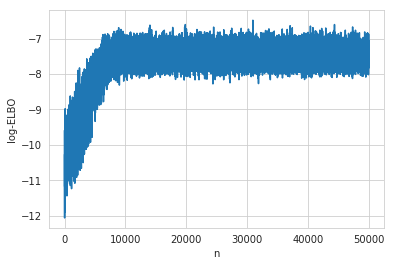

In [48]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(iso_advi.hist),
     'n': np.arange(iso_advi.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [ ]:
advi_trace = iso_advi.sample()

In [41]:
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sigma,0.986591,0.004688,0.000211,0.977794,0.996113
abs_mode_cardinals,0.005282,0.006172,0.000309,-0.005617,0.018031
abs_mode_obliques,-0.016850,0.005967,0.000260,-0.028443,-0.005667
abs_amplitude_cardinals,-0.011484,0.006911,0.000343,-0.025966,0.000461
abs_amplitude_obliques,-0.006734,0.004919,0.000222,-0.017171,0.002994
rel_mode_cardinals,0.008205,0.006301,0.000250,-0.004276,0.019636
rel_mode_obliques,-0.005207,0.005915,0.000272,-0.017243,0.005472
rel_amplitude_cardinals,-0.002655,0.006057,0.000266,-0.014645,0.008385
rel_amplitude_obliques,-0.007648,0.004066,0.000181,-0.015111,0.000722
sf_ecc_slope,0.731845,0.003047,0.000122,0.726343,0.737703


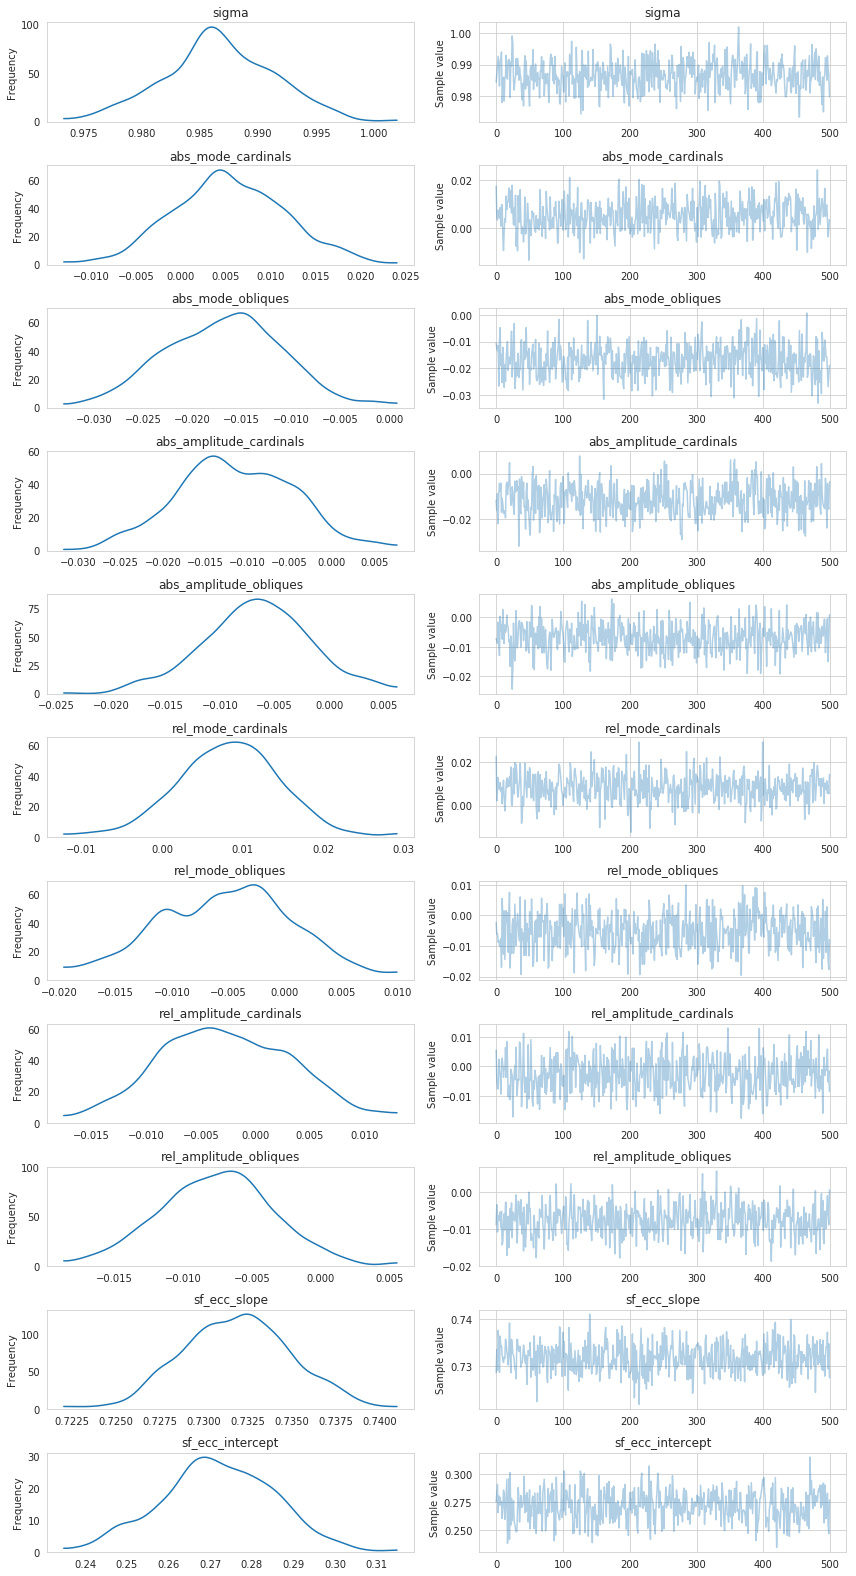

In [42]:
pm.traceplot(advi_trace, );#['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']);

In [65]:
#Can't use the pm.init_nuts (or similarly through pm.sample) because it doesn't let us override the callbacks, so here we implement our own version
import logging
_log = logging.getLogger('pymc3')
def convert_advi_to_nuts_init(approx, method='advi', chains=1, model=None, **kwargs):
    """Set up the mass matrix initialization for NUTS starting from a fit ADVI approximation.

    NUTS convergence and sampling speed is extremely dependent on the
    choice of mass/scaling matrix. This function implements different
    methods for choosing or adapting the mass matrix.

    Parameters
    ----------
    approx : output of pm.fit
        ADVI approximation of the posterior to adapt to NUTS initialization.
    method : str
        Initialization method to use.

        * advi+adapt_diag : adapt the resulting diagonal mass matrix based on the
          sample variance of the tuning samples.
        * advi+adapt_diag_grad : adapt the resulting diagonal mass matrix based
          on the variance of the gradients during tuning. This is **experimental** and might be
          removed in a future release.
        * advi : Use ADVI's approximation to estimate posterior mean and diagonal mass matrix.
    chains : int
        Number of jobs to start.
    model : Model (optional if in `with` context)
    **kwargs : keyword arguments
        Extra keyword arguments are forwarded to pymc3.NUTS.

    Returns
    -------
    start : pymc3.model.Point
        Starting point for sampler
    nuts_sampler : pymc3.step_methods.NUTS
        Instantiated and initialized NUTS sampler object
    """
    model = pm.model.modelcontext(model)

    vars = kwargs.get('vars', model.vars)
    if set(vars) != set(model.vars):
        raise ValueError('Must use init_nuts on all variables of a model.')
    if not pm.model.all_continuous(vars):
        raise ValueError('init_nuts can only be used for models with only '
                         'continuous variables.')

    if not isinstance(method, str):
        raise TypeError('method must be a string.')

    if method is not None:
        method = method.lower()

    _log.info('Initializing NUTS using {}...'.format(method))

    if method == 'advi+adapt_diag_grad':
        start = approx.sample(draws=chains)
        start = list(start)
        stds = approx.bij.rmap(approx.std.eval())
        cov = model.dict_to_array(stds) ** 2
        mean = approx.bij.rmap(approx.mean.get_value())
        mean = model.dict_to_array(mean)
        weight = 50
        potential = pm.step_methods.hmc.quadpotential.QuadPotentialDiagAdaptGrad(
            model.ndim, mean, cov, weight)
    elif method == 'advi+adapt_diag':
        start = approx.sample(draws=chains)
        start = list(start)
        stds = approx.bij.rmap(approx.std.eval())
        cov = model.dict_to_array(stds) ** 2
        mean = approx.bij.rmap(approx.mean.get_value())
        mean = model.dict_to_array(mean)
        weight = 50
        potential = pm.step_methods.hmc.quadpotential.QuadPotentialDiagAdapt(
            model.ndim, mean, cov, weight)
    elif method == 'advi':
        start = approx.sample(draws=chains)
        start = list(start)
        stds = approx.bij.rmap(approx.std.eval())
        cov = model.dict_to_array(stds) ** 2
        potential = pm.step_methods.hmc.quadpotential.QuadPotentialDiag(cov)

    step = pm.NUTS(potential=potential, model=model, **kwargs)

    return start, step

In [60]:
iso_model, _ = pymc_log_gauss_donut(features, targets, precision, 'full')
with iso_model:
    start, step = init_nuts('advi+adapt_diag_grad', 10, n_init=50000, callbacks=[])
    #iso_trace = pm.sample(500, step=step, start=start, chains=10, cores=20, nuts_kwargs={'target_accept': .99})
#prior = pm.sample_prior_predictive(model=iso_model)
#post = pm.sample_posterior_predictive(iso_trace, 500, iso_model)

Initializing NUTS using advi+adapt_diag_grad...
Average Loss = 81,124: 100%|█████████▉| 49959/50000 [01:49<00:00, 454.48it/s]Interrupted at 49,999 [99%]: Average Loss = 2.9943e+05


In [6]:
data = az.from_pymc3(iso_trace, prior=prior, posterior_predictive=post)

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


In [27]:
pm.summary(iso_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.976895,0.001167,0.000017,0.974655,0.979200,4615.015112,0.999468
abs_mode_cardinals,-0.003644,0.000914,0.000012,-0.005475,-0.001988,4734.968761,1.000769
abs_mode_obliques,0.000319,0.000918,0.000014,-0.001458,0.002084,4713.624849,1.001459
rel_mode_cardinals,-0.004522,0.000932,0.000014,-0.006307,-0.002716,4930.922061,0.999645
rel_mode_obliques,0.002176,0.000728,0.000011,0.000779,0.003645,4592.383567,1.000070
sf_ecc_slope,0.737414,0.001156,0.000018,0.735044,0.739603,4354.163644,0.999561
sf_ecc_intercept,0.223785,0.004824,0.000064,0.214749,0.233325,4378.786783,0.999568
abs_amplitude_cardinals,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
abs_amplitude_obliques,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
rel_amplitude_cardinals,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [28]:
data.posterior.sigma.mean('draw')

<xarray.DataArray 'sigma' (chain: 10)>
array([1.602253e-03, 1.374637e+00, 1.237148e+00, 1.637830e+00, 1.526511e+00,
       9.768780e-01, 2.057209e+00, 1.068711e+00, 1.218435e+00, 1.319241e+00])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9

In [29]:
data.posterior.sf_ecc_slope.mean('draw')

<xarray.DataArray 'sf_ecc_slope' (chain: 10)>
array([-0.028784,  1.022146,  0.922808,  1.382798,  1.233152,  0.737365,
        1.625437, -6.064605,  0.873978,  0.938674])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9

In [30]:
data.posterior.sf_ecc_intercept.mean('draw')

<xarray.DataArray 'sf_ecc_intercept' (chain: 10)>
array([ 3.154334e-01,  6.218093e-01,  1.903786e-01,  3.705491e-01,
       -1.292371e-01,  2.238005e-01,  2.636419e+00, -5.738690e+00,
        2.150982e-01, -2.715902e-03])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9

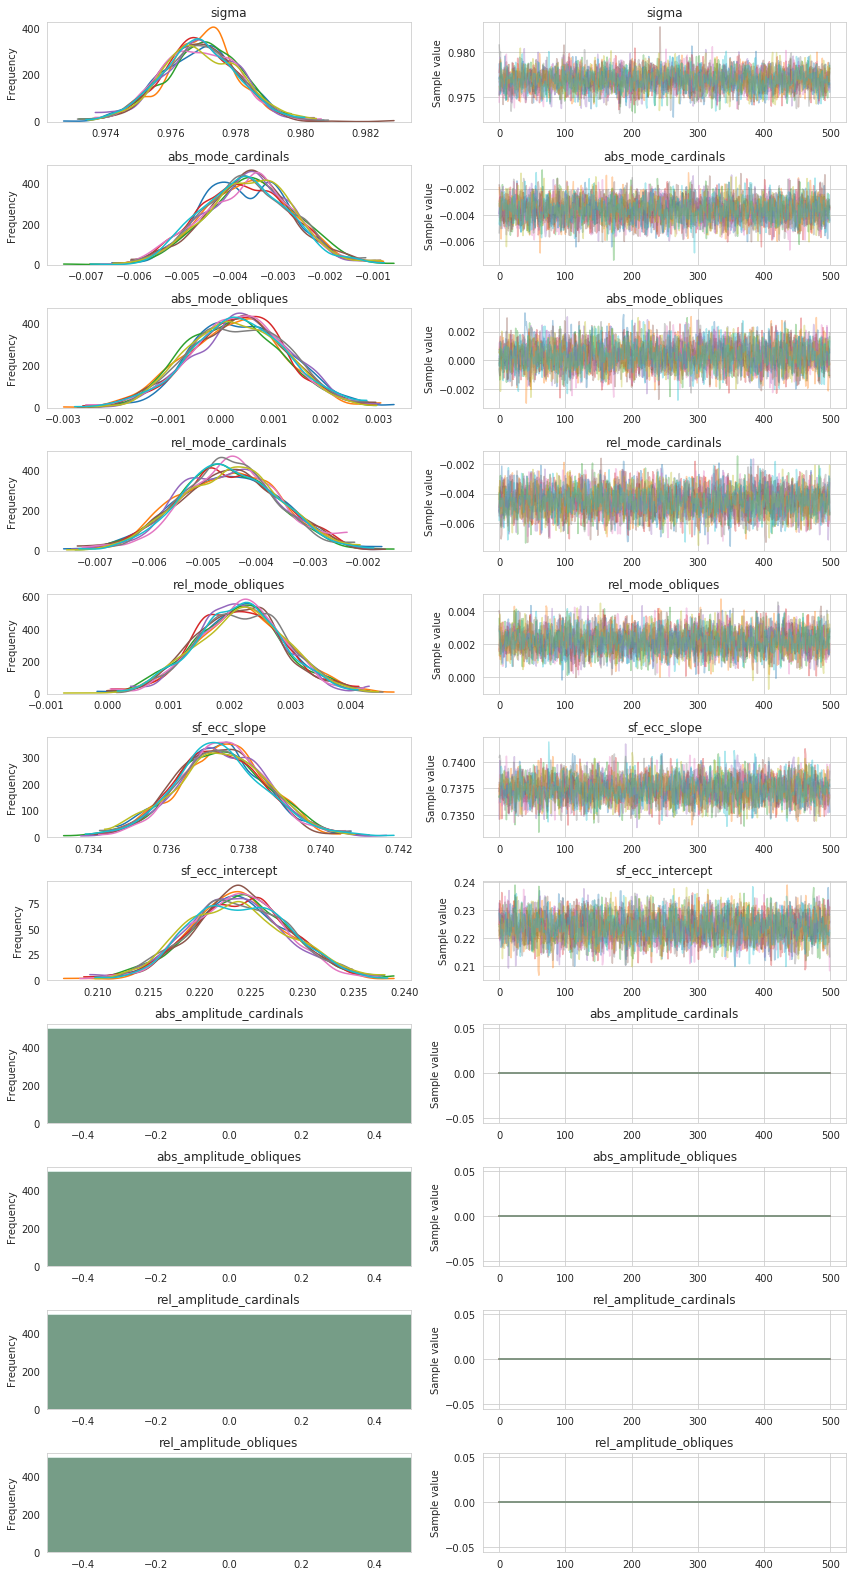

In [31]:
pm.traceplot(iso_trace);

# Pyro
Need to rescale predictions and targets

In [38]:
dataset = sfp.model.FirstLevelDataset(df_path, device,)# sfp.model.construct_df_filter('drop_voxels_with_negative_amplitudes,drop_voxels_near_border'))
dataloader = torchdata.DataLoader(dataset, 1)

In [8]:
model = sfp.model.LogGaussianDonut('iso', 'full')

def call_model(features, precision):
    priors = {}
    for k, v in model.named_parameters():
        if not v.requires_grad:
            # we only want to deal with the parameters that require training
            continue
        if k == 'sigma':
            priors[k] = pyro.distributions.Normal(features.new_tensor(1), features.new_tensor(.25))
        elif k.startswith('sf'):
            priors[k] = pyro.distributions.Normal(features.new_tensor(.5), features.new_tensor(.25))
        else:
            #priors[k] = pyro.distributions.Gamma(1, 5)
            priors[k] = pyro.distributions.Normal(features.new_tensor(.5), features.new_tensor(.25))
    lifted_module = pyro.random_module('module', model, priors)
    lifted_model = lifted_module()
    predictions = lifted_model(*features.transpose(2,0).transpose(2,1))
    rescaled_predictions = predictions / predictions.norm(2, -1, True)
    return pyro.sample('noisy_predictions', pyro.distributions.Normal(rescaled_predictions, 1./precision))

def call_conditioned_model(features, target, precision):
    rescaled_target = target / target.norm(2, -1, True)
    return pyro.condition(call_model, data={'noisy_predictions': rescaled_target})(features, precision)

In [9]:
features = []
targets = []
precision = []
for i in range(len(dataset)):
    f,t,p = dataset[i]
    features.append(f.reshape((*f.shape, 1)))
    targets.append(t.reshape(*t.shape, 1))
    precision.append(p.reshape(*p.shape, 1))
features = torch.cat(features, -1).transpose(2, 0).transpose(2, 1)
targets = torch.cat(targets, -1).transpose(1, 0)
precision = torch.cat(precision, -1).transpose(1, 0)

In [10]:
pyro.clear_param_store()
nuts_kernel = mcmc.NUTS(call_conditioned_model, adapt_step_size=True)
hmc = mcmc.MCMC(nuts_kernel, num_samples=100, num_chains=1)

In [11]:
hmc_posterior = hmc.run(features, targets, precision)

Sample: 100%|██████████| 200/200 [00:07<00:00, 25.65it/s, step size=1.80e-01, acc. rate=0.905]


In [12]:
pyro_data_iso = az.from_pyro(hmc_posterior)

In [17]:
pyro_data_iso.posterior

<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 100)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables:
    module$$$sigma             (chain, draw) float64 0.9697 0.9786 ... 0.9788
    module$$$sf_ecc_slope      (chain, draw) float64 0.74 0.733 ... 0.7448
    module$$$sf_ecc_intercept  (chain, draw) float64 0.1867 0.2494 ... 0.1943
Attributes:
    created_at:                 2019-04-02T21:30:08.832168
    inference_library:          pyro
    inference_library_version:  0.3.1

In [18]:
pyro_data_full.posterior

<xarray.Dataset>
Dimensions:                           (chain: 1, draw: 100)
Coordinates:
  * chain                             (chain) int64 0
  * draw                              (draw) int64 0 1 2 3 4 ... 95 96 97 98 99
Data variables:
    module$$$sigma                    (chain, draw) float64 0.9748 ... 0.9711
    module$$$abs_amplitude_cardinals  (chain, draw) float64 0.003297 ... -0.002975
    module$$$abs_amplitude_obliques   (chain, draw) float64 -0.004145 ... 0.001009
    module$$$rel_amplitude_cardinals  (chain, draw) float64 -0.002018 ... -0.00707
    module$$$rel_amplitude_obliques   (chain, draw) float64 0.003386 ... -0.0009014
    module$$$abs_mode_cardinals       (chain, draw) float64 -0.001487 ... -0.005134
    module$$$abs_mode_obliques        (chain, draw) float64 -0.002583 ... -0.002509
    module$$$rel_mode_cardinals       (chain, draw) float64 -0.00794 ... -0.001675
    module$$$rel_mode_obliques        (chain, draw) float64 -0.0003585 ... 0.000501
    module$$$s

In [217]:
params = ['module$$$'+i[0] for i in model.named_parameters()]
marginals = hmc_posterior.marginal(params)
marginals.support().keys()

odict_keys(['module$$$sigma', 'module$$$abs_amplitude_cardinals', 'module$$$abs_amplitude_obliques', 'module$$$rel_amplitude_cardinals', 'module$$$rel_amplitude_obliques', 'module$$$abs_mode_cardinals', 'module$$$abs_mode_obliques', 'module$$$rel_mode_cardinals', 'module$$$rel_mode_obliques', 'module$$$sf_ecc_slope', 'module$$$sf_ecc_intercept'])

In [218]:
samples = {}
for k, v in marginals.support().items():
    samples[k.replace('module$$$', '')] = v
samples = pd.DataFrame(samples)
samples['sample_num'] = range(len(samples))
samples = pd.melt(samples, 'sample_num', var_name='model_parameter')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


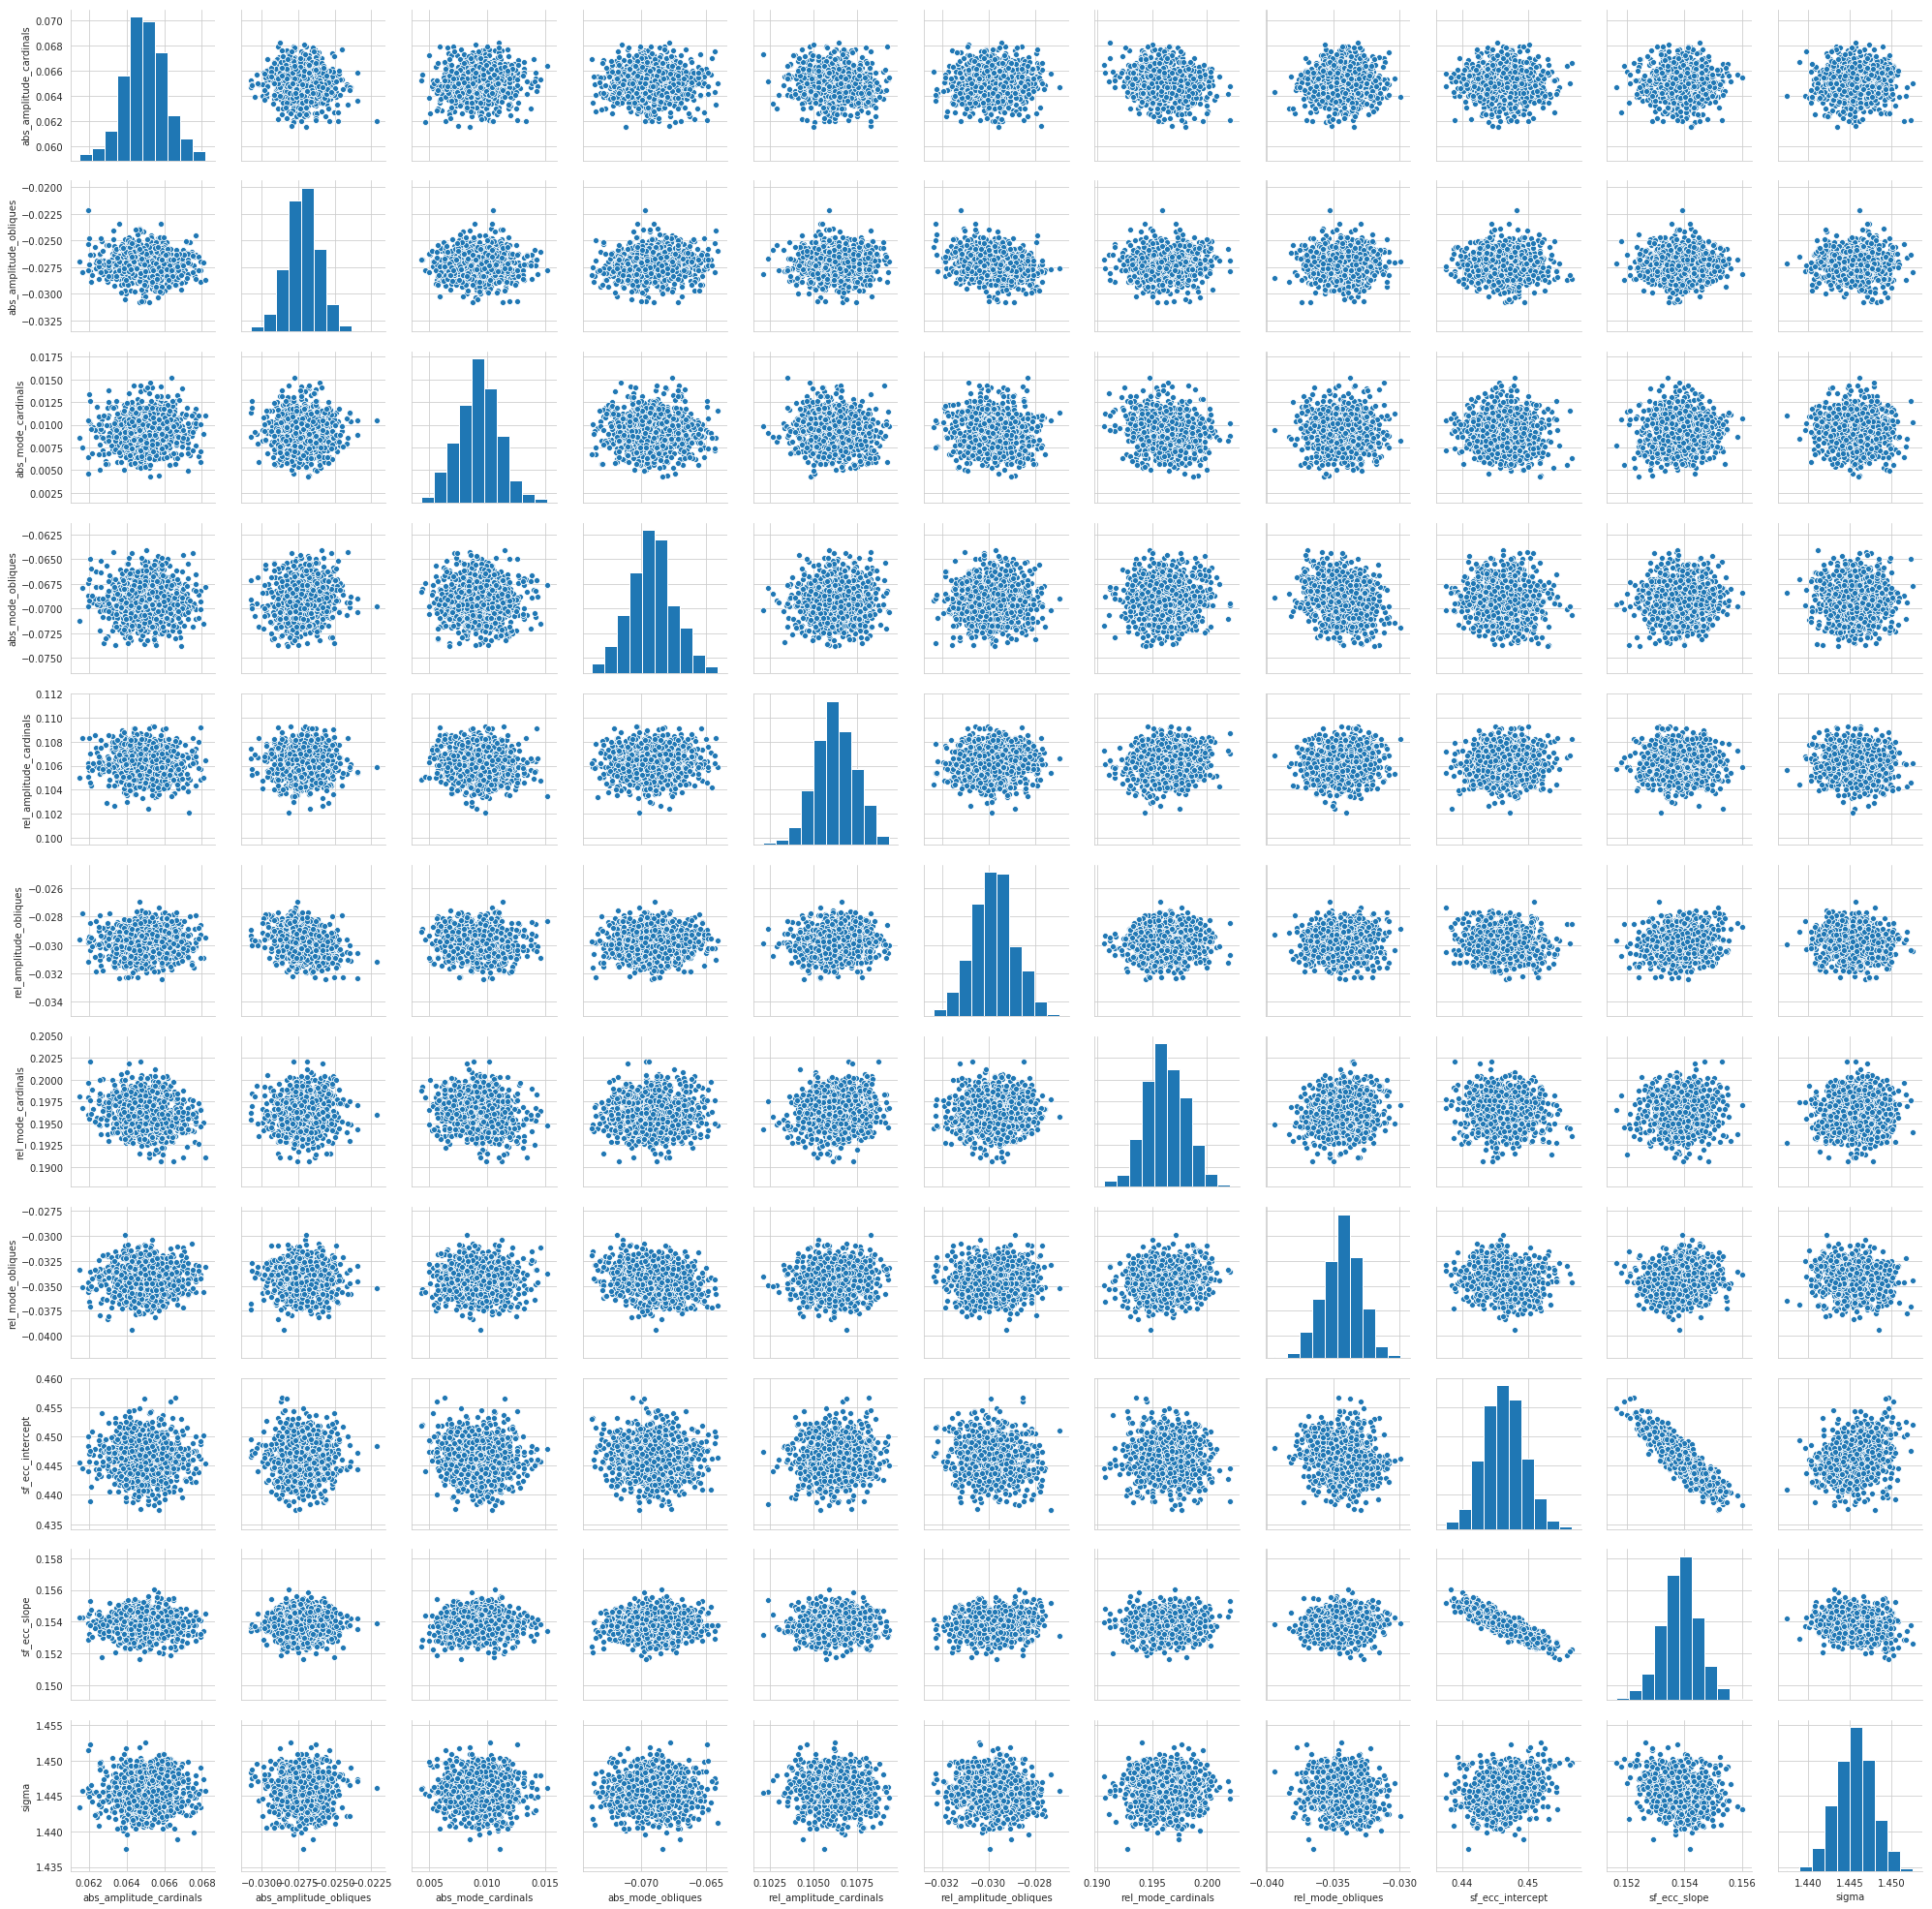

In [221]:
sns.pairplot(samples.pivot('sample_num', 'model_parameter', 'value'))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


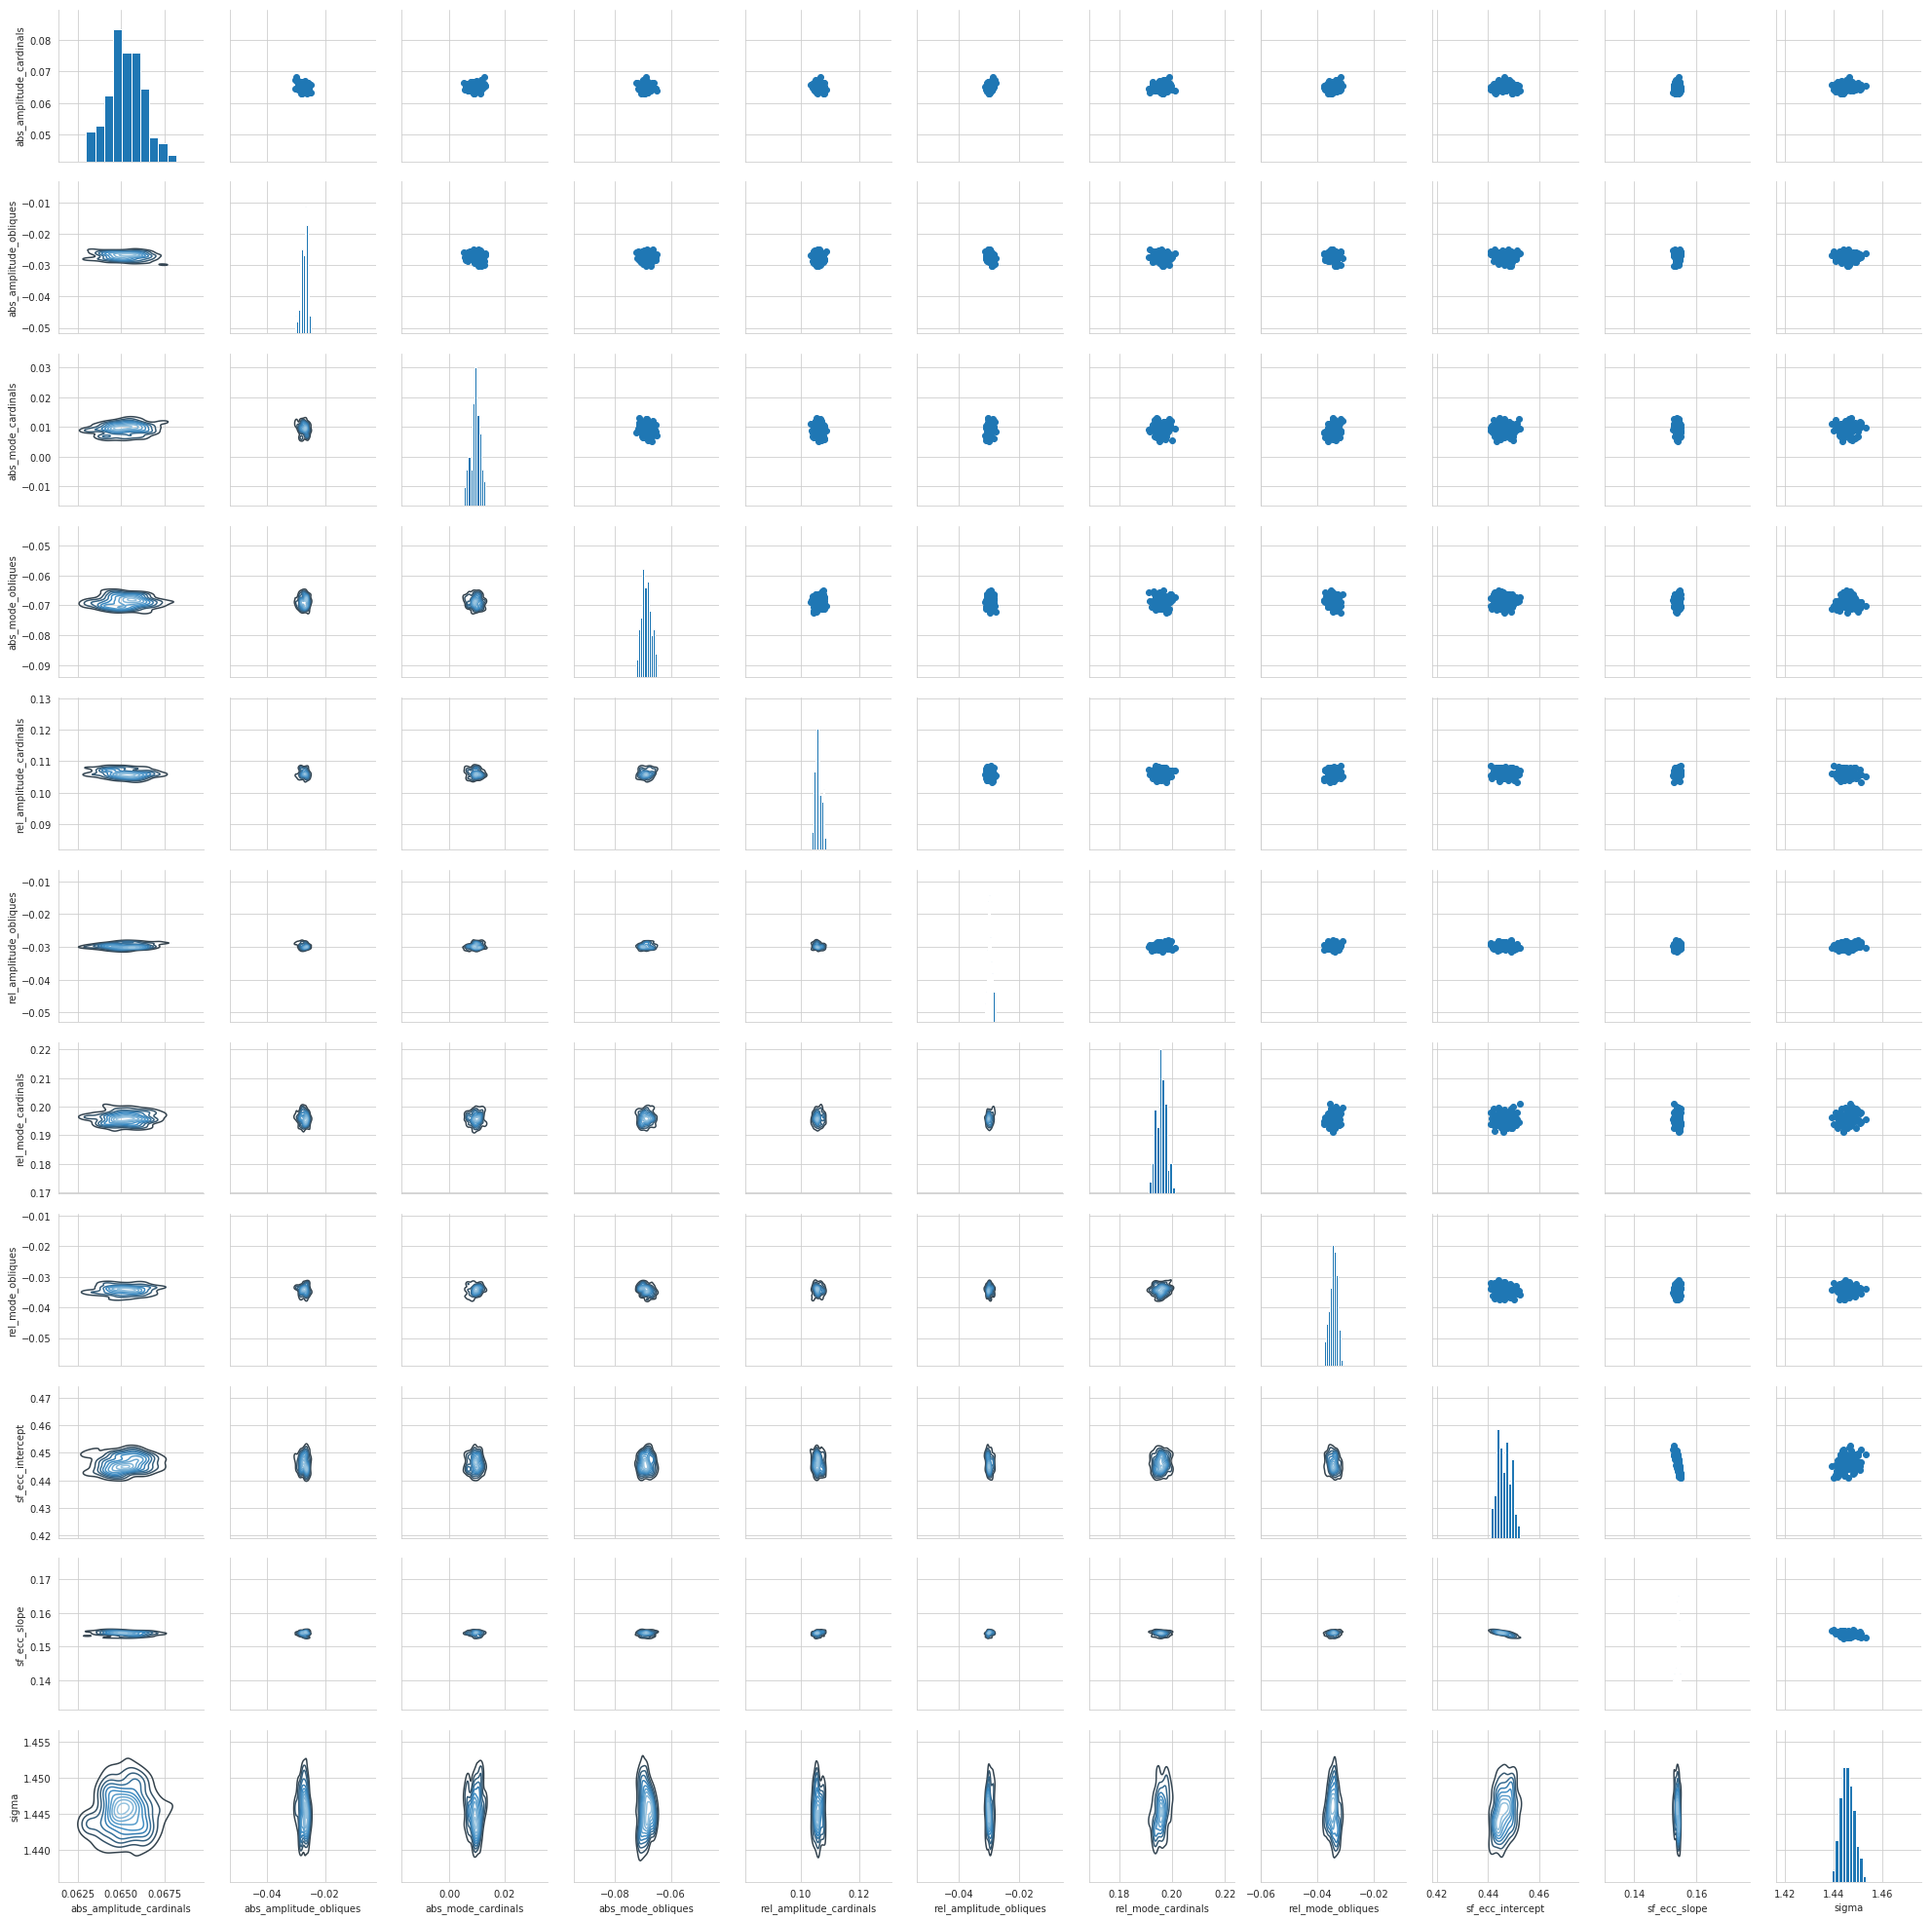

In [213]:
g = sns.PairGrid(samples.pivot('sample_num', 'model_parameter', 'value'))
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


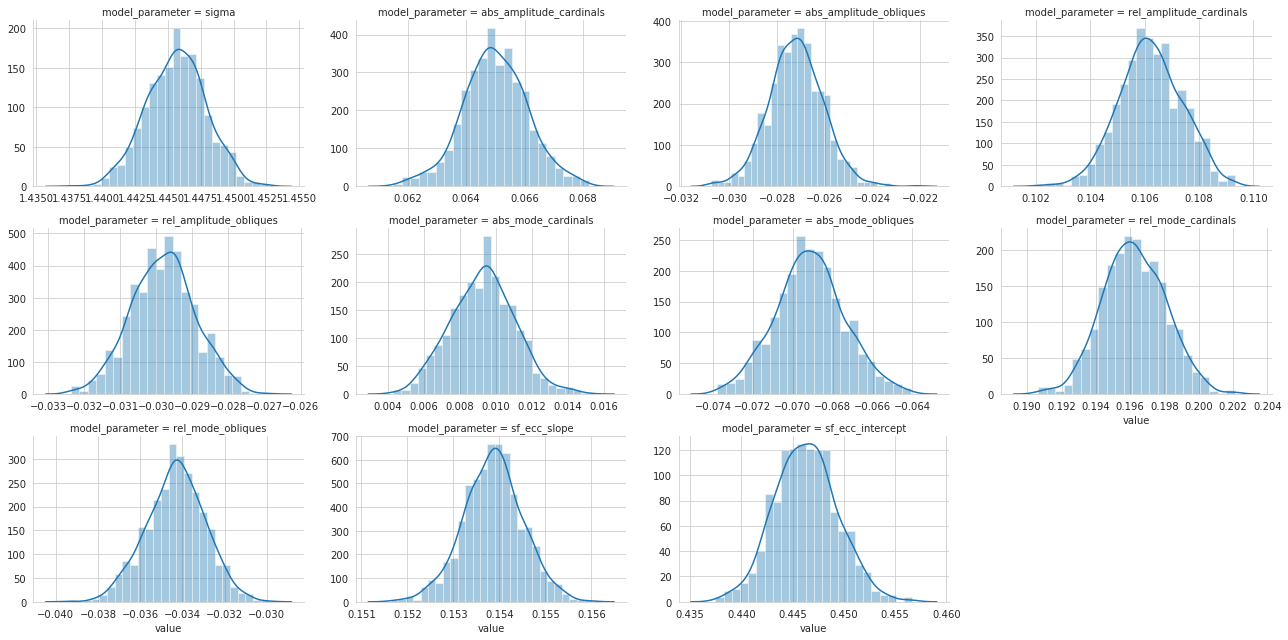

In [219]:
g = sns.FacetGrid(samples, col='model_parameter', col_wrap=4, sharex=False, sharey=False, aspect=1.5)
g.map(sns.distplot, 'value')

In [142]:
# cusum plot:
means = {}
cusum = {}
for p in params:
    means[p] = marginals.support()[p].mean()
    cusum[p] = []
    for t in range(len(marginals.support()[p])):
        cusum[p].append((marginals.support()[p][:t] - means[p]).sum())

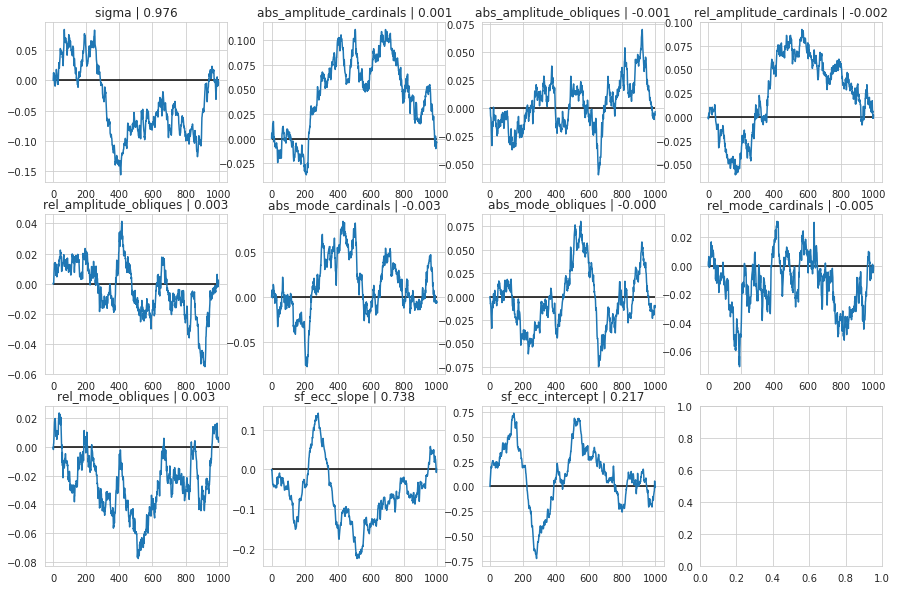

In [143]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for ax, p in zip(axes.flatten(), params):
    ax.plot(cusum[p])
    ax.hlines(0, 0, len(cusum[p]))
    ax.set_title("%s | %.03f" % (p.replace('module$$$', ''), marginals.support()[p].mean()))

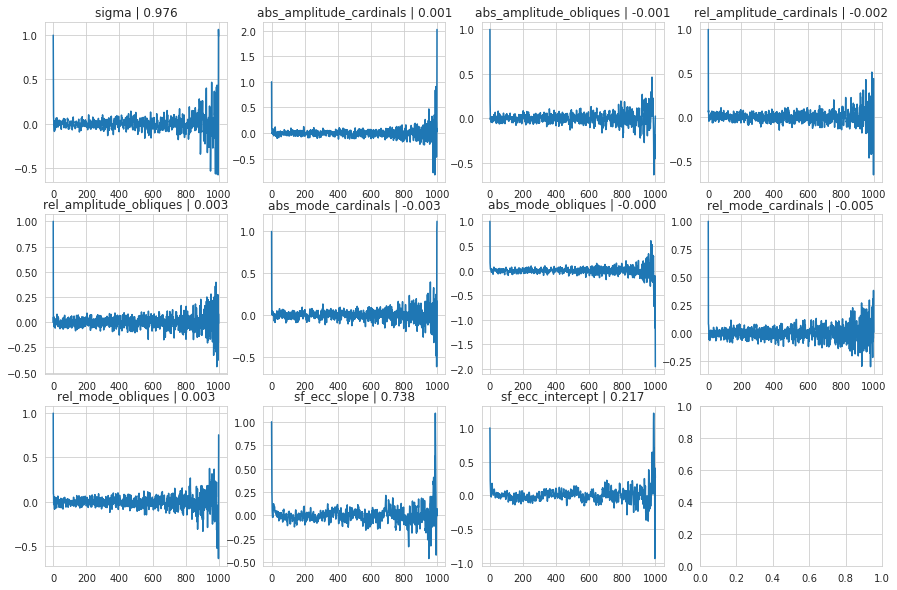

In [151]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for ax, p in zip(axes.flatten(), params):
    ax.plot(pyro.ops.stats.autocorrelation(marginals.support()[p]).numpy())
    ax.set_title("%s | %.03f" % (p.replace('module$$$', ''), marginals.support()[p].mean()))